In [1]:
from utils_project import *

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initial n=579
Validation n=255
Combined n=834
Questionnaire items loaded


# Behavioral affiliation & power are correlated in Initial but not Validation sample
- So not a perfect validation but basically in line with our wants
- But when add in dots, both samples have correlations between affil & power


Interesting pattern of the characters increasingly getting affiliated as they become more "goal-directed"...

,sample,X,y,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,p,p_left,p_right,sig
1,Initial,Intercept + affil_mean_mean + demo_age + demo_...,power_mean_mean,affil_mean_mean,555.0,0.077,167.47,67.20,0.034,0.011,0.012,0.055,3.107,0.002,0.999,9.949e-04,True
1,Validation,Intercept + affil_mean_mean + demo_age + demo_...,power_mean_mean,affil_mean_mean,226.0,0.049,150.26,69.36,0.019,0.018,-0.017,0.054,1.047,0.296,0.852,1.480e-01,False


,sample,X,y,x,dof,adj_rsq,bic,aic,beta,se,95%_lb,95%_ub,t,p,p_left,p_right,sig
1,Initial,Intercept + dots_affil_mean + demo_age + demo_...,dots_power_mean,dots_affil_mean,555.0,0.054,-169.1,-269.37,0.028,0.008,0.012,0.044,3.466,5.695e-04,1.000,2.848e-04,True
1,Validation,Intercept + dots_affil_mean + demo_age + demo_...,dots_power_mean,dots_affil_mean,226.0,0.012,-14.2,-95.10,0.030,0.013,0.004,0.056,2.281,2.348e-02,0.988,1.174e-02,True


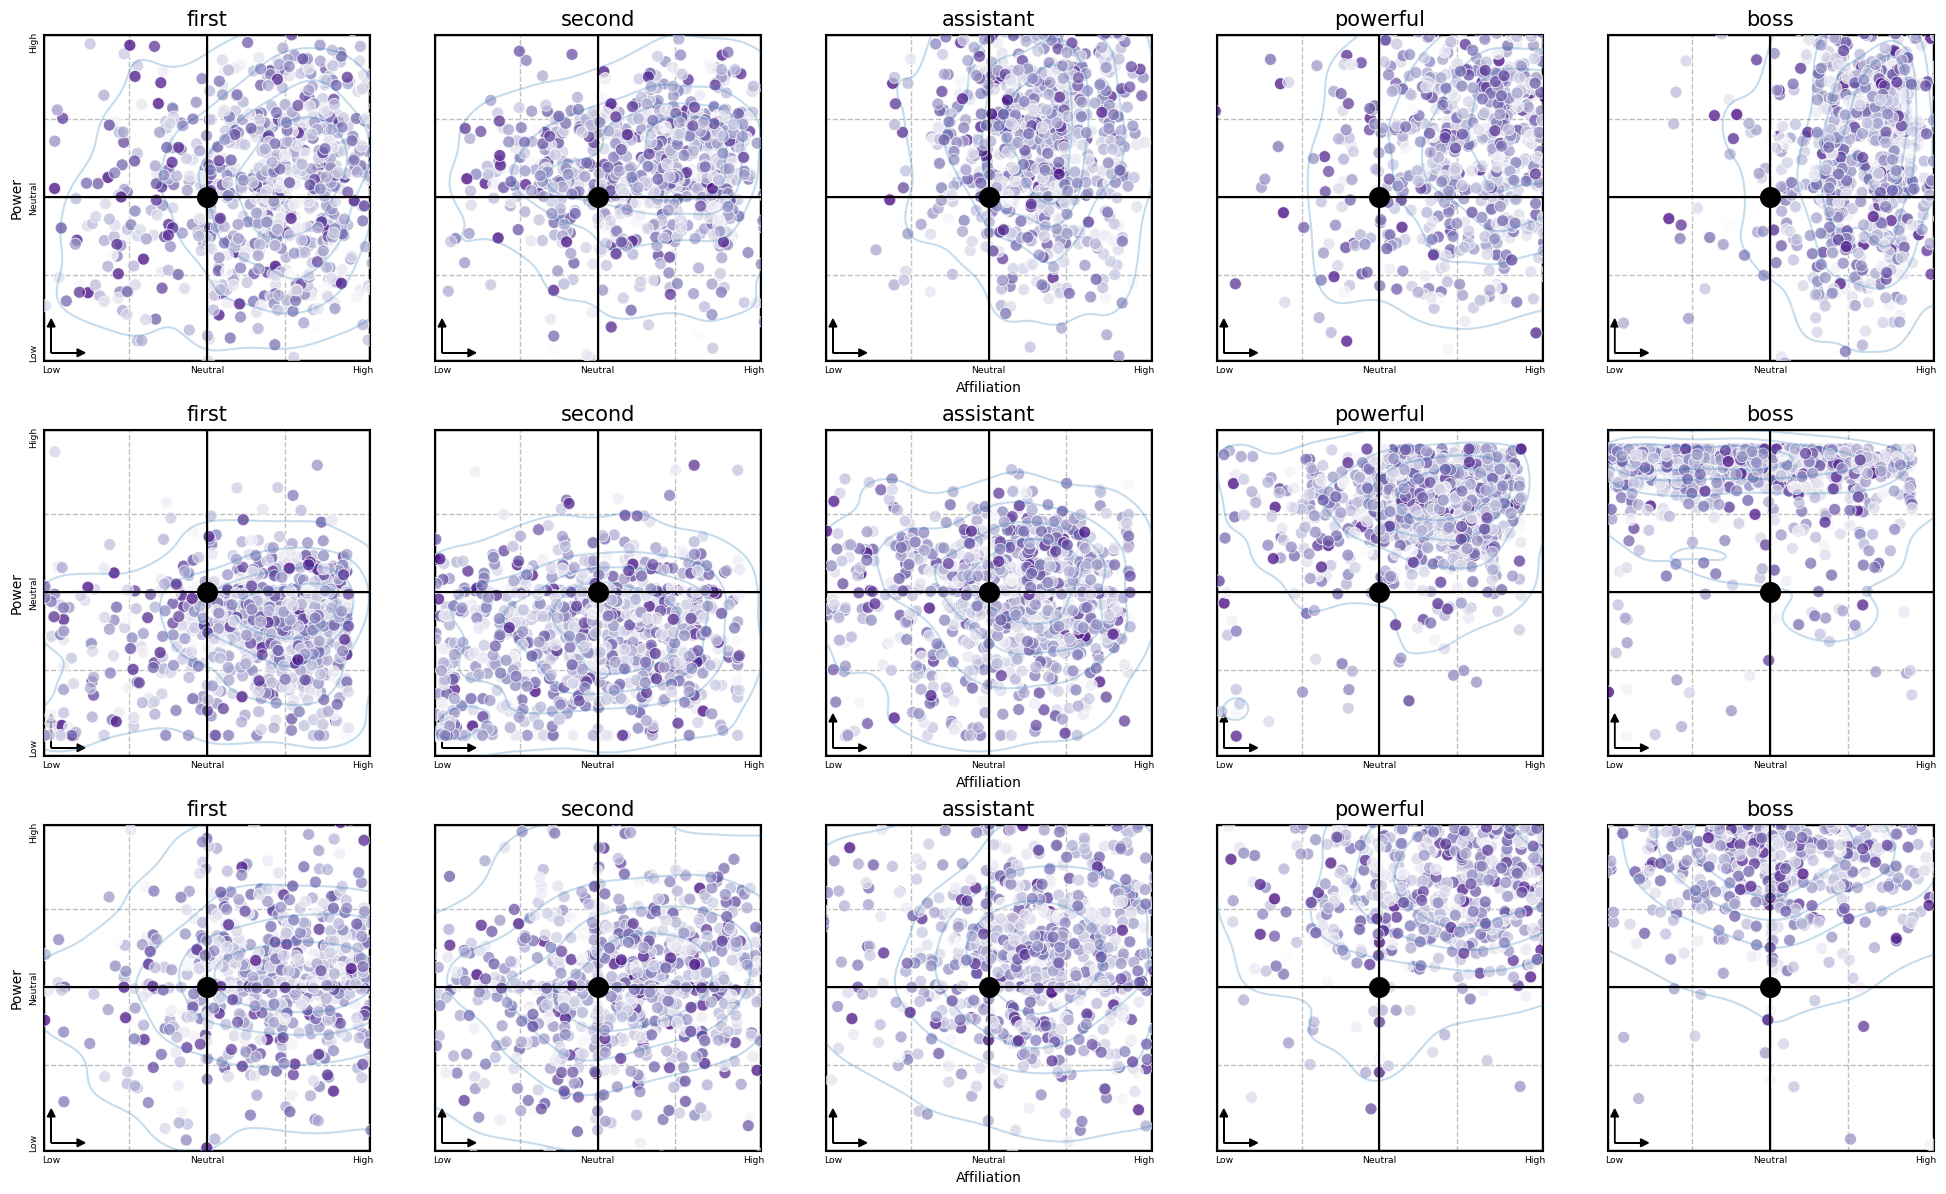

In [2]:
def jitter(values,j):
    return values + np.random.normal(j,0.1,values.shape)

display(run_replicated_ols('affil_mean_mean', 'power_mean_mean', controls=all_controls, data=data, alpha=0.05, which_p='p', filter_repl=False))
display(run_replicated_ols('dots_affil_mean', 'dots_power_mean', controls=all_controls, data=data, alpha=0.05, which_p='p', filter_repl=False))

fig, axs = plt.subplots(3, 5, figsize=(20, 12), sharey=True)
for r, role in enumerate(character_roles[:5]):

    affil = jitter(data[f'affil_mean_{role}'], 0.1)
    power = jitter(data[f'power_mean_{role}'], 0.1)
    beh_xy = np.vstack([affil, power]).T
    
    affil = data[f'{role}_dots_affil'].values
    power = data[f'{role}_dots_power'].values
    dots_xy = np.vstack([affil, power]).T

    affil = data[f'{role}_dots_affil_adj'].values
    power = data[f'{role}_dots_power_adj'].values
    dots_xy_adj = np.vstack([affil, power]).T

    lsas  = data['lsas_av_score'].values

    for c, xy in enumerate([beh_xy, dots_xy, dots_xy_adj]):
        ax = axs[c, r]
        sns.kdeplot(ax=ax, x=xy[:,0], y=xy[:,1], palette='Blues', levels=5, fill=False, alpha=.25)
        sns.scatterplot(ax=ax, x=xy[:,0], y=xy[:,1], c=lsas, cmap='Purples', s=75, alpha=.75)
        ax.set_title(role, fontdict={'fontsize':15})
        ax.axvline(x=0, color='black')
        ax.axhline(y=0, color='black')
        plot_social_space(ax, label_fontsize=10)
        if r == 0: ax.set_ylabel('Power', fontdict={'fontsize':10})
        else:      ax.set_ylabel('')
        if r == 2: ax.set_xlabel('Affiliation', fontdict={'fontsize':10})
        else:      ax.set_xlabel('')

plt.tight_layout()

In [ ]:
plot_space_density(data['dots_power_mean'].values, data['dots_affil_mean'].values, regression=False)
plot_space_density(data['dots_power_mean_adj'].values, data['dots_affil_mean_adj'].values, regression=False)

# Subjective mappings validate the behavioral mappings: locations are similar
- Doesnt necessarily have to precisely match but good to validate some basic assumptions
    - Behavior reflects relationship (e.g., the other person can see behavior, respond to it, etc)
    - Dots should reflect subjective model of the relationship
- Dots and task locations are correlated, using a variety of approaches (permutations, ols, rsa, cca)
    - smaller distances than shuffled characters distances
    - dimension tendency ~correlates with dots in OLS
    - pairwise distances correlate in RSA
    - Adjusting by the neutral characters dots locations improves the correlation



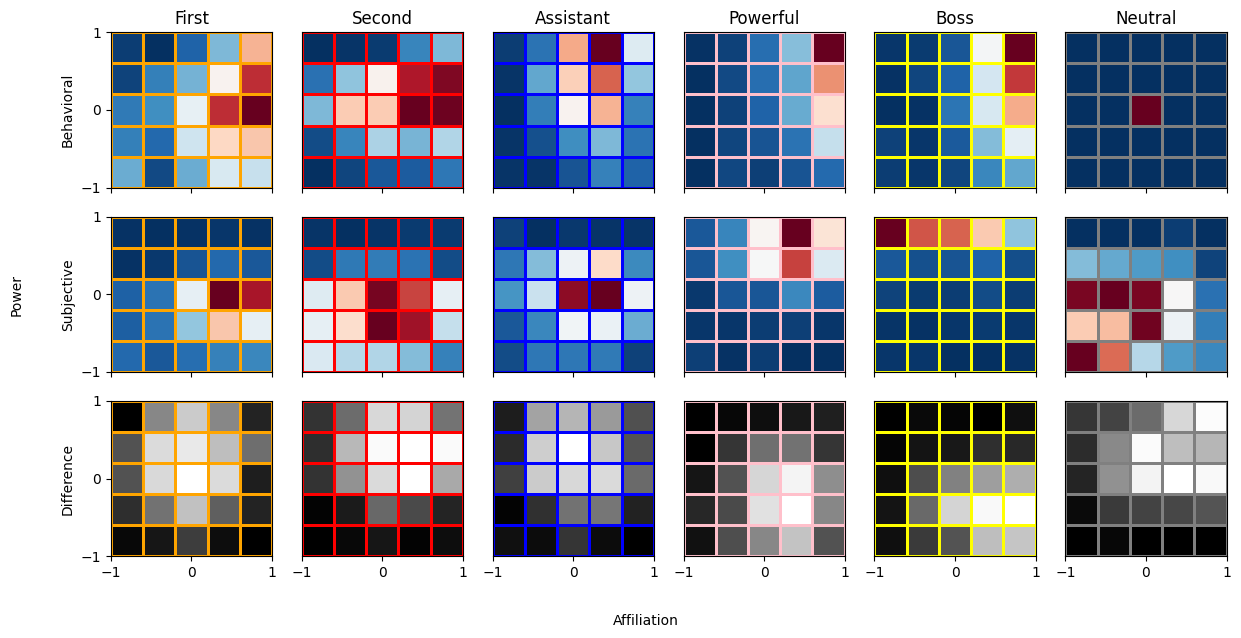

In [2]:
nrows = 3
fig, axs = plt.subplots(nrows, 6, figsize=(12, 2*nrows), sharex=True, sharey=True)
fig.subplots_adjust(top=0.95)
fig.text(0.5, -0.05, 'Affiliation', ha='center')
fig.text(-0.03, 0.5, 'Power',va='center', rotation='vertical')

norm_binedges = np.array([-1, -.6, -.2, .2, .6, 1]) 
bins = [norm_binedges, norm_binedges]
for c, role in enumerate(character_roles):
    
    axs[0,c].set_title(character_roles[c].capitalize())

    # behavior
    ax = axs[0,c]
    task_affil, task_power = data[f'affil_mean_{role}'], data[f'power_mean_{role}']
    ax.hist2d(task_affil, task_power, cmap='RdBu_r',
              bins=bins, color=character_colors[c])
    ax.set_ylabel('Behavioral')

    # subjective
    ax = axs[1,c]
    dots_affil, dots_power = data[f'{role}_dots_affil'], data[f'{role}_dots_power']
    ax.hist2d(dots_affil, dots_power, cmap='RdBu_r', 
              bins=bins, color=character_colors[c])
    ax.set_ylabel('Subjective')

    # difference
    ax = axs[2,c]
    ax.hist2d(task_affil-dots_affil, task_power-dots_power, cmap='Greys_r',
              bins=bins, color=character_colors[c])
    ax.set_ylabel('Difference')

    # # subjective (neutral adj.)
    # ax = axs[3,c]
    # dots_affil_adj, dots_power_adj = data[f'{role}_dots_affil_adj'], data[f'{role}_dots_power_adj']
    # ax.hist2d(dots_affil_adj, dots_power_adj, cmap='RdBu_r', 
    #           bins=bins, color=character_colors[c])
    # ax.set_ylabel('Subjective (neutral adj.)')

    # # difference (neutral adj.)
    # ax = axs[4,c]
    # ax.hist2d(task_affil-dots_affil_adj, task_power-dots_power_adj, cmap='Greys_r',
    #           bins=bins, color=character_colors[c])
    # ax.set_ylabel('Difference (neutral adj.)')

    for ax in axs[:, c]:
        ax.set_yticks([-1,0,1])
        ax.set_xticks([-1,0,1])

    if c > 0: [axs[r,c].axes.get_yaxis().set_visible(False) for r in np.arange(0, nrows)] 

plt.tight_layout()

# fig.savefig(fig_dir + "/behavior_dots.png", dpi=150)
# plt.show()

In [3]:
for s, sample in enumerate(samples):

    print(f'\n{sample}\n')

    df = sample_dict[sample]['data']

    # permutation test
    perm_diffs = (df['beh_dots_dist_mean'] - df['beh_dots_dist_shuff_mean']) / df['beh_dots_dist_shuff_std']
    df['beh_dots_dist_z'] = perm_diffs
    t, tp = ttest_1samp(perm_diffs, popmean=0, alternative='less')
    dof = len(perm_diffs) - 1

    # rsa
    taus = np.array(df['beh_dots_pw_dist_tau'].values)
    taus = taus[np.isfinite(taus)]
    w, wp = wilcoxon(taus, alternative='greater')

    # ols
    ols_res = []
    for dv, bv in itertools.product(['dots_power_mean', 'dots_affil_mean'], 
                                    ['power_mean_mean', 'affil_mean_mean']):
        ols_df = run_ols(X=bv, y=dv, data=df, covariates=all_controls)[0]
        ols_df.insert(0, 'sample', sample)
        ols_res.append(ols_df[ols_df['x'].isin([bv])])

    # print results
    print(f'permutation test: df({dof}) t={t:.2f}, p={tp:.4f}')
    print(f'rsa: w={w:.2f}, p={wp:.4f}')
    print_df(pd.concat(ols_res))



#------------------------------------------#
# RSA across dims etc...
#------------------------------------------#

#     # get character data
#     affil = df[[f'affil_mean_{role}' for role in roles]]
#     power = df[[f'power_mean_{role}' for role in roles]]
#     dots_affil = df[[f'{role}_dots_affil' for role in roles]]
#     dots_power = df[[f'{role}_dots_power' for role in roles]]

#     # get rdvs
#     affil_rdvs = [get_rdv(af.values.reshape(-1, 1)) for _, af in affil.iterrows()]
#     power_rdvs = [get_rdv(pw.values.reshape(-1, 1)) for _, pw in power.iterrows()]
#     dots_affil_rdvs = [get_rdv(daf.values.reshape(-1, 1)) for _, daf in dots_affil.iterrows()]
#     dots_power_rdvs = [get_rdv(dpw.values.reshape(-1, 1)) for _, dpw in dots_power.iterrows()]

#     # get kendall taus 
#     affil_taus  = np.array([kendalltau(affil_rdvs[i], dots_affil_rdvs[i])[0] for i in range(n)])
#     power_taus  = np.array([kendalltau(power_rdvs[i], dots_power_rdvs[i])[0] for i in range(n)])
#     dots_taus   = [kendalltau(dots_affil_rdvs[i], dots_power_rdvs[i])[0] for i in range(n)]
#     task_taus   = [kendalltau(affil_rdvs[i], power_rdvs[i])[0] for i in range(n)]
#     cross1_taus = [kendalltau(affil_rdvs[i], dots_power_rdvs[i])[0] for i in range(n)]
#     cross2_taus = [kendalltau(power_rdvs[i], dots_affil_rdvs[i])[0] for i in range(n)]

#     affil_p = wilcoxon(affil_taus[np.isfinite(affil_taus)], alternative='greater')[1]
#     power_p = wilcoxon(power_taus[np.isfinite(power_taus)], alternative='greater')[1]

#     print(f'{sample} n={np.sum(np.isfinite(affil_taus))}: affil p={affil_p:.3f}, power p={power_p:.3f}')


Initial

permutation test: df(578) t=-18.29, p=0.0000
rsa: w=108773.50, p=0.0000
|    | sample   | X                                                                                                                                                                                                       | y               | x               |   dof |   adj_rsq |     bic |     aic |       beta |         se |       95%_lb |    95%_ub |        t |           p |   p_left |     p_right |
|---:|:---------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------|:----------------|------:|----------:|--------:|--------:|-----------:|-----------:|-------------:|----------:|---------:|------------:|---------:|------------:|
|  1 | Initial  | Intercept + power_mean_mean + demo_age + demo_gender_1W + demo_race_white + iq_score + disorder + ofb 

In [ ]:
from sklearn.cross_decomposition import CCA, PLSCanonical
from statsmodels.multivariate.cancorr import CanCorr
from stats import calc_perm_pvalue

def plot_cca_biplot(scores, loadings):

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for ax, data_name in zip(axs, ['X', 'Y']):
        
        # subsets for scores and loadings for the current data (X or Y)
        data_scores   = scores[[f'{data_name}_CC01', f'{data_name}_CC02']]
        data_loadings = loadings[[f'{data_name}_C1', f'{data_name}_C2']]

        # Scatter plot of scores
        ax.scatter(data_scores[f'{data_name}_CC01'], data_scores[f'{data_name}_CC02'], 
                   alpha=0.33, edgecolor='black', linewidth=0.5)

        # Add loadings vectors
        for idx, row in data_loadings.iterrows():
            ax.arrow(0, 0, row[f'{data_name}_C1'], row[f'{data_name}_C2'], color='black', linewidth=2)
            ax.text(row[f'{data_name}_C1'], row[f'{data_name}_C2'], idx, fontsize=15)

        ax.set_title(f'{data_name} Biplot')
        ax.set_xlabel('First Canonical Variate')
        ax.set_ylabel('Second Canonical Variate')

    plt.tight_layout()
    plt.show()

class CrossDecompose(object):

    '''[By Matthew Schafer; github: @matty-gee; 2020ish]'''
    
    def __init__(self, n_comps=2, scale=True, mode='pls'):

        self.n_comps = n_comps
        self.comp_range = range(1, n_comps+1)
        self.scale = scale
        self.fitted = False
        self.mode = mode
        self.errors = []

        if mode == 'cca':
            # symmetric deflation of X & Y 
            self.model = CCA
        elif mode == 'pls_canonical':
            self.model = PLSCanonical
            # canonical pls is also symmetric but may outperform cca when n_features > n_samples
            # can only find n_components <= min(n_samples, n_features)
        elif mode == 'pls':
            # asymmetric deflation of X & Y
            self.model = PLSRegression

    def _check_input(self, X, Y):
        # if not a dataframe, then create list for index
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=[f'X{i}' for i in range(1,X.shape[1]+1)])
        if Y is not None and not isinstance(Y, pd.DataFrame):
            if isinstance(Y, pd.Series): 
                Y = Y.to_frame() # turn into a dataframe
            else: 
                if len(Y.shape) == 1: Y = Y.reshape(-1,1)
                Y = pd.DataFrame(Y, columns=[f'Y{i}' for i in range(1,Y.shape[1]+1)])

        return X, Y

    def multivariate_residuals(self, X, Z):
        # return residuals from multivariate regression of X on z
        # z is the covariate to regress out
        # make sure z i right shape
        Z = np.array(Z)[:, np.newaxis]
        ols = LinearRegression().fit(Z, X)
        return X - ols.predict(Z)

    def fit(self, X, Y, Z=None, n_comps=None):

        #---------------------------------------------------------------
        # check inputs
        #---------------------------------------------------------------

        X, Y = self._check_input(X, Y)

        # if n_comps or scal are none use self
        if n_comps is None: n_comps = self.n_comps
        
        # check if n_comps is valid
        if self.mode in ['cca', 'pls_canonical']:
            max_n_comps = min(X.shape[0], X.shape[1], Y.shape[1])
            if not n_comps <= max_n_comps:
                print(f'n_comps must be <= min(n_samples, n_features, n_targets); changing to {max_n_comps}')
                n_comps = max_n_comps


        #---------------------------------------------------------------
        # partial out effects of Z (optional)
        #---------------------------------------------------------------

        if Z is not None:
            X = self.multivariate_residuals(X, Z)
            Y = self.multivariate_residuals(Y, Z)

        #---------------------------------------------------------------
        # fit the model
        #---------------------------------------------------------------

        self.model_ = self.model(n_components=n_comps, scale=self.scale)
        self.model_.fit(X, Y)
        self.fitted = True

        #---------------------------------------------------------------
        # canonical covariates (aka scores)
        # result of rotations projecting the datasets into the canonical/shared space
        #---------------------------------------------------------------

        if self.mode == 'pls':
            X_c, Y_c = self.model_.x_scores_, self.model_.y_scores_
        elif self.mode == 'cca':
            X_c, Y_c = self.model_.transform(X, Y)
        
        self.X_scores    = pd.DataFrame(X_c, columns=[f'X_C0{i}' for i in range(1, n_comps+1)])
        self.Y_scores    = pd.DataFrame(Y_c, columns=[f'Y_C0{i}' for i in range(1, n_comps+1)])
        self.X_rotations = pd.DataFrame(self.model_.x_rotations_, columns=[f'X_C0{i}' for i in range(1, n_comps+1)], index=X.columns)
        self.Y_rotations = pd.DataFrame(self.model_.y_rotations_, columns=[f'Y_C0{i}' for i in range(1, n_comps+1)], index=Y.columns)

        # scores should equal the rotations multiplied by the variables
        # assert np.allclose(X @ self.X_rotations, X_c, rtol=0.01), 'X @ x_rotations != X_rotated'
        # assert np.allclose(Y @ self.Y_rotations, Y_c, rtol=0.01), 'Y @ y_rotations != Y_rotated'

        #---------------------------------------------------------------
        # canonical residuals
        #---------------------------------------------------------------

        self.Y_predictions = self.model_.predict(X)
        self.Y_residuals   = Y - self.Y_predictions

        #---------------------------------------------------------------
        # canonical correlations: correlations between X & Y canonical covariates
        # - in statsmodels: cca.cancorr_
        #---------------------------------------------------------------

        self.can_corrs = pd.DataFrame(np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_comps).T[np.newaxis,:], 
                                      columns=[f'CC_0{i}' for i in range(1, n_comps+1)])

        #---------------------------------------------------------------
        # weights: translate the [deflated] X & Y matrices to X & Y scores
        # - X_deflated @ X_weights = X_scores
        # - deflated matrices have previous variance accounted for subtracted out
        # - CCA has symmetrical deflation, PLS is asymmetrical (X only)
        # - weights are not very interpretable; better to use loadings
        #---------------------------------------------------------------
        
        #---------------------------------------------------------------
        # loadings: translate the X & Y scores *back* to the original X & Y matrices
        # - interpretable than weights b/c they are not on the deflated matrices
        # - X_scores @ X_loadings = X (should == corr(X, X_c))
        # cross-loadings: the relationship between X & Y to opposite canonical covariates
        #---------------------------------------------------------------

        self.X_loadings = pd.DataFrame(self.model_.x_loadings_.T, 
                                       index=[f'loading_0{i}' for i in range(1, n_comps+1)], columns=X.columns)
        self.Y_loadings = pd.DataFrame(self.model_.y_loadings_.T, 
                                       index=[f'loading_0{i}' for i in range(1, n_comps+1)], columns=Y.columns)

        # assert np.allclose(X_cc @ self.model_.x_loadings_.T, X, atol=0.01), 'x_scores @ x_loadings.T != X'
        # assert np.allclose(Y_cc @ self.model_.y_loadings_.T, Y, atol=0.01), 'y_scores @ x_loadings.T != Y'

        # ## get all loadings, including cross-loadings !! poss. problem is the cca.x_loadings_ is a bit diff!!
        # self.loadings = pd.DataFrame(columns=['X_CC01', 'X_CC02', 'Y_CC01', 'Y_CC02']) # make this dynamically
        # for fname, features in {'X':X, 'Y':Y}.items():
        #     for f in range(features.shape[1]): # assumes same number of features in both and components for each
        #         for c in range(n_comps):
        #             self.loadings.loc[f'{fname}{f+1}', f'Y_CC0{c+1}'] = np.corrcoef(features.iloc[:,f], Y_cc[:,c])[0,1]
        #             self.loadings.loc[f'{fname}{f+1}', f'X_CC0{c+1}'] = np.corrcoef(features.iloc[:,f], X_cc[:,c])[0,1]

    def predict(self, X, Y=None, plot=False, colors=None):

        X, Y = self._check_input(X, Y)
        if self.fitted is False:
            print('Fit first...')
            return None

        Y_pred = self.model_.predict(X)
        if plot is True and Y is not None:
            self.plot_predictions(Y, Y_pred, X, colors=colors)

        return Y_pred

    def fit_predict(self, X, Y=None, Z=None, n_comps=None, plot=False):
            
        if n_comps is None: n_comps = self.n_comps
        self.fit(X, Y, Z, n_comps)
        return self.predict(X, Y, plot)
    
    def transform(self, X, Y=None):
        return self.model_.transform(X, Y)

    def fit_transform(self, X, Y=None, Z=None, n_comps=None):
        self.fit(X, Y, Z, n_comps)
        return self.model_.transform(X, Y)

    def inverse_transform(self, X_cc, Y_cc):
        # only exact if n_comps = n_features
        return self.model_.inverse_transform(X_cc, Y_cc)

    def score(self, X, Y):
        return self.model_.score(X, Y)

    # other methods
    def optimize_fit(self, X, Y, max_comps=None, folds=5, metric='MSE', \
                    plot=True, colors=None):

        if max_comps is None: comp_range = np.arange(1, self.n_comps+1) # 1,2
        else:                 comp_range = np.arange(1, max_comps+1)

        #------------------------------------------------------------
        # find minimal mse for number of components using cross-validation
        # - options of MSE & MAE (L1 loss)
        #------------------------------------------------------------

        comps_mse, comps_mae = [], []
        for i in comp_range:
            Y_pred = cross_val_predict(PLSRegression(n_components=i), X, Y, cv=folds) 
            comps_mse.append(mean_squared_error(Y, Y_pred))
            comps_mae.append(mean_absolute_error(Y, Y_pred))
            # calcuate mean absolute error too

        # see if there is a difference between mse and mae
        msemin, maemin = np.argmin(comps_mse), np.argmin(comps_mae)
        # if maemin != msemin: 
        #     print('MSE and MAE disagree on optimal number of components')
        
        if metric is 'MSE': 
            self.n_comps = msemin + 1
            metric_min = msemin
            metric_vals = comps_mse
        elif metric is 'MAE':
            self.n_comps = maemin + 1
            metric_min = maemin
            metric_vals = comps_mae

        #------------------------------------------------------------
        # Refit w/ optimal number of components
        #------------------------------------------------------------
        
        # refit 'calibration' w/ entire dataset
        fitted = self.fit(X, Y, n_comps=self.n_comps)
        Y_preds = self.predict(X, Y, plot=plot, colors=colors)
        r2  = r2_score(Y, Y_preds)
        mse = mean_squared_error(Y, Y_preds)
        mae = mean_absolute_error(Y, Y_preds)

        # Cross-validation
        fitted_cv = self.model(n_components=self.n_comps).fit(X, Y)
        Y_preds_cv = cross_val_predict(fitted_cv, X, Y, cv=folds)    
        r2_cv = r2_score(Y, Y_preds_cv)
        mse_cv = mean_squared_error(Y, Y_preds_cv)
        mae_cv = mean_absolute_error(Y, Y_preds_cv)

        #------------------------------------------------------------
        # print/plot out metrics
        #------------------------------------------------------------

        if plot is True:

            print(f"{metric} suggested number of components = {self.n_comps}")

            # plot the mse as a function of component number
            fig = plt.figure(figsize=(3,3))
            plt.plot(comp_range, np.array(metric_vals), '-v', color='blue', mfc='blue')
            plt.plot(comp_range[metric_min], np.array(metric_vals)[metric_min], 'P', ms=10, mfc='red')
            plt.xlabel('Number of components')
            plt.ylabel(f'{folds}-fold CV {metric}')
            plt.xlim(left=1)
            plt.xticks(comp_range)
            plt.show()

            print(f"{'Model':<15} {'R2':<10} {'MSE':<10} {'MAE':<10}")
            print(f"{'Calibration':<15} {np.round(r2, 3):<10} {np.round(mse,3):<10} {np.round(mae,3):<10}")
            print(f"{f'{folds}-fold CV':<15} {np.round(r2_cv, 3):<10} {np.round(mse_cv,3):<10} {np.round(mae_cv,3):<10}")

    def plot_predictions(self, Y, Y_pred, X, colors=None):
        
        n_targets = Y.shape[1]
        X_transformed = self.model_.transform(X)
        n_comps = X_transformed.shape[1]

        if not isinstance(Y, pd.DataFrame): Y = pd.DataFrame(Y)

        fig, axs  = plt.subplots(n_targets, n_comps+1, figsize=(3*(n_comps+1), 3*n_targets))
        
        for y in range(n_targets):

            if (n_targets > 1):    ax = axs[y, 0]
            elif (n_targets == 1): ax = axs[0]

            #------------------------------------------------------------
            # plot the predicted Y against real Y 
            #------------------------------------------------------------

            ax.scatter(x=Y_pred[:, y], y=Y.iloc[:, y], alpha=0.75, edgecolor='black', linewidth=0.5, c=colors)
            ax.set_title(f"Y {y + 1}")
            ax.set(xlabel=f"Predicted Y {y + 1}", ylabel=f"True Y {y + 1}")
            
            # annotate plot with correlation
            r = np.corrcoef(Y.iloc[:, y], Y_pred[:, y])[0, 1]
            ax.annotate(f"r  = {np.round(r, 3)}", xy=(0.05, 0.9), fontsize=9, xycoords='axes fraction')           
            
            # make sure the axes are same
            ylim = ax.get_ylim()
            ax.set_xlim(ylim)
            ax.plot(ylim, ylim, ls="--", color='black')
            
            for c in range(n_comps):

                if (n_targets > 1):    ax = axs[y, c+1]
                elif (n_targets == 1): ax = axs[c+1]
            
                # plot the projected X values/scores against the Y values
                ax.scatter(x=X_transformed[:, c], y=Y.iloc[:, y], alpha=0.50, label="observed", 
                           edgecolor='black', linewidth=0.25, c=colors, marker='o')
                ax.scatter(x=X_transformed[:, c], y=Y_pred[:, y], alpha=0.75, label="predicted", 
                           edgecolor='black', linewidth=2, c=colors, marker='o')
                           
                r = np.corrcoef(X_transformed[:, c], Y.iloc[:, y])[0, 1]
                ax.annotate(f"r  = {np.round(r, 3)}", xy=(0.05, 0.9), fontsize=9, xycoords='axes fraction') 
                ax.set(xlabel=f"Projected X {c + 1}", ylabel=f"True y {y + 1}", title=f"Component {c+1}")

                # same y axis
                ax.set_ylabel("")
                # ax.set_ylim(ylim)

            if c == n_comps - 1: ax.legend().set_visible(True)
        
        plt.tight_layout()
        plt.show()

    def plot_X_loadings(self, X_loadings=None, items=True):
  
        colors = ['red', 'blue', 'purple', 'green', 'lavender', 'grey', 'fuchsia', 'orange', 'dodgerblue', 
                    'yellow', 'orchid', 'indigo', 'aqua','palegreen', 'silver', 'plum', 'fuchsia', 'coral',
                    'gold', 'pink','slategray', 'forestgreen','peachpuff','honeydew','brown','olivedrab',
                    'darkturquoise', 'tan', 'springgreen', 'mintcream','navajowhite','chocolate','lightblue','chartreuse',
                    'lime','yellowgreen','khaki','gold','teal','tomato']

        if X_loadings is None: X_loadings = self.X_loadings
        xvars = X_loadings.index

        # organize the coloring scheme
        plot_colors = []
        if items:
            plot_labels = [xvar.split('_')[0] for xvar in xvars]
            plot_labels = list(np.unique(plot_labels))
            plot_colors = [colors[plot_labels.index(xvar.split('_')[0])] for xvar in xvars]
        else:
            plot_labels = xvars
            plot_colors = colors[:len(plot_labels)]
            
        # plot loadings
        fig, axs = plt.subplots(self.n_comps, 1, figsize=(11, 2.5*self.n_comps))
        for i in range(self.n_comps):
            if self.n_comps > 1: ax = axs[i]
            else:                ax = axs
            ax.bar(np.arange(len(X_loadings)), X_loadings.iloc[:,i], 
                   color=plot_colors, edgecolor='black', linewidth=0.5)
            ax.set_title(f'Component {i+1} X loadings', fontsize=14)
            ax.set_xticks([])
            # ax.set_xticks(np.arange(len(X_loadings)))
            # ax.set_xticklabels([X_loadings.index], rotation=90, fontsize=10)

        patches = [mpatches.Patch(color=colors[i], label=plot_labels[i]) for i in range(len(plot_labels))]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()
   
    def get_top_features(self, X_loadings=None, n_features=50):
        # maybe eventually I want to do in cross-validation loop?
        if X_loadings is None: X_loadings = self.X_loadings
        X_loadings = np.abs(X_loadings)
        top_features = []
        for i in range(self.n_comps):
            features = X_loadings.iloc[:,i].sort_values(ascending=False).index[:n_features]
            top_features.append(list(features))
        return top_features

def run_cca(X, Y, Z=None, n_shuffles=10):

    # inputs: drop nans, zscore
    if Z is None:
        mask = np.isfinite(Y).all(axis=1) & np.isfinite(X).all(axis=1)    
    elif Z is not None: 
        mask = np.isfinite(Y).all(axis=1) & np.isfinite(X).all(axis=1) & np.isfinite(Z)
        Z = scipy.stats.zscore(Z[mask], 0)
    Y, X = scipy.stats.zscore(Y[mask], 0), scipy.stats.zscore(X[mask], 0)

    # compute simple correlations between features
    XY = pd.concat([X, Y], axis=1)
    corrmat = XY.corr()
    pvalue_df = compute_symmetric(XY, run_ols_symmetric) # plot ols pvalues

    # compute canonical correlations
    cca = CrossDecompose(n_comps=2, scale=False, mode='cca')
    cca.fit(X, Y, Z)
    ccs = cca.can_corrs.values.flatten()

    # permutation test
    X_shuffles = shuffle_rows(X, n_shuffles)
    perm_ccs = []
    for i, X_shuffled in enumerate(X_shuffles):
        print(f'Running shuffle {i+1} of {len(X_shuffles)}', end='\r')
        cca_perm = CrossDecompose(n_comps=2, scale=False, mode='cca')
        _ = cca_perm.fit(X_shuffled, Y)
        perm_ccs.append(cca_perm.can_corrs.values.flatten())
    perm_ccs = np.vstack(perm_ccs)

    #------------------------------------------------------------------------

    fig, axs = plt.subplots(1, 4, figsize=(20, 4))

    ax = axs[0]
    plot_corrmat(corrmat, precomputed=True, pvalue_df=pvalue_df, ax=ax)
    ax.set_title('Correlation matrix', fontsize=title_fontsize)

    # plot the correlations between the latent variable scores
    # plot_regplot(pls.X_scores['X_CC01'], pls.Y_scores['Y_CC01'], ax=axs[0], color='purple')
    # plot_regplot(pls.X_scores['X_CC02'], pls.Y_scores['Y_CC02'], ax=axs[1], color='purple')

    # canonical correlations (pearson r, always positive) are the max corr between any pair of linear combinations of the two sets of variables
    for c in range(2):
        ax = axs[c+1]
        plot_histplot(perm_ccs[:,c], ax=ax)
        ax.axvline(ccs[c], color='black', linestyle='--')
        pvalue = calc_perm_pvalue(ccs[c], perm_ccs[:,c], alternative='greater')
        ax.text(ccs[c]-0.01, n_shuffles/10, f'p={pvalue:.3f}', fontsize=label_fontsize, ha='right', va='bottom')
        ax.set_xlabel('Canonical Correlation', fontsize=label_fontsize)
        if c == 0: ax.set_ylabel('Frequency', fontsize=label_fontsize)
        else:      ax.set_ylabel('')
        ax.set_title(f'CC {c+1}: permutation test', fontsize=title_fontsize)
    plt.tight_layout()

    # plot the loadings in 
    ax = axs[3]
    ax.set_title('Loadings in projected', fontsize=title_fontsize)
    plot_loadings(cca.X_loadings, ax=ax, color='black')
    plot_loadings(cca.Y_loadings, ax=ax, color='red')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal', 'box')
    plt.tight_layout()

    # plot_cca_biplot(cca_res['scores'], cca_res['loadings'])

# generic helpers
def shuffle_rows(data, n_shuffles=100):
    ''' shuffle row wise n_times '''
    data = np.array(data)
    return np.array([np.random.permutation(data) for _ in range(n_shuffles)])

def corrcoef_symmetric(col1, col2):
    return np.corrcoef(col1, col2)[0,1]

def compute_symmetric(df, func):
    ''' compute pairwise tests, returns a symmetric matrix '''
    columns = df.columns
    results = pd.DataFrame(index=columns, columns=columns)
    for i, j in itertools.product(range(len(columns)), range(len(columns))):
        results.iloc[i, j] = results.iloc[j, i] = func(df[columns[i]], df[columns[j]])
    return results

def run_ols_symmetric(col1, col2):
    ols_df = run_ols(col1, col2)[0]
    return ols_df[ols_df['x']==col1.name]['p'].values[0]

# specifc
def plot_corrmat(df, precomputed=False, pvalue_df=None, ax=None):
    '''Plot a graphical correlation matrix for a dataframe.
    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    # Compute the correlation matrix for the received dataframe
    corr_mat = df if precomputed else df.corr()

    # Plot the correlation matrix
    if ax is None: fig, ax = plt.subplots(figsize=(5, 5))
    ax.grid(False)
    cax = ax.matshow(corr_mat, cmap='RdBu_r', vmin=-1, vmax=1)
    if pvalue_df is not None:
        for i, j in itertools.product(range(len(corr_mat.columns)), range(len(corr_mat.columns))):
            if i > j:
                p = pvalue_df.iloc[i, j]
                if p < 0.005:
                    ax.annotate('***', (j, i), color='black', fontsize=12, ha='center', va='center')
                    ax.annotate('***', (i, j), color='black', fontsize=12, ha='center', va='center')
                elif p < 0.01:
                    ax.annotate('**', (j, i), color='black', fontsize=12, ha='center', va='center')
                    ax.annotate('**', (i, j), color='black', fontsize=12, ha='center', va='center')
                elif p < 0.05:
                    ax.annotate('*', (j, i), color='black', fontsize=12, ha='center', va='center')
                    ax.annotate('*', (i, j), color='black', fontsize=12, ha='center', va='center')
    ax.set_xticks(range(len(corr_mat.columns)), corr_mat.columns, rotation=90, fontsize=8)
    ax.set_yticks(range(len(corr_mat.columns)), corr_mat.columns, fontsize=8)
    #cbar = ax.colorbar(cax, ticks=[-1, -.5, 0, .5, 1], aspect=40, shrink=.8)

    return ax

def plot_loadings(loadings, unit=True, ax=None, color='black'):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    for i in range(len(loadings)):
        x, y = loadings.iloc[i,:]
        if unit: x, y = x / np.sqrt(x**2 + y**2), y / np.sqrt(x**2 + y**2) # unit norm
        ax.arrow(0, 0, x, y, color=color, linewidth=2)
        ax.text(x, y, loadings.columns[i], fontsize=12, color=color)  

In [ ]:
for sample in samples:
    df = sample_dict[sample]['data']
    task = df[['affil_mean_mean', 'power_mean_mean']]
    dots = df[['dots_affil_mean', 'dots_power_mean']]
    covariate = df[social_factor]
    run_cca(task, dots, covariate, n_shuffles=1000)

# TODO: flesh this out more....

### Estimate characterwise behavior-dots distances: find where the distortions are
More affiliation and power in behavior than in dots


Boss is the most discrepant
- Maybe we can learn soemthing from this boss thing? 
    - E.g., are the nicest acting peopel the most likely to affiliate, despite their internal feelings? 
    
1D measures: dots - behavior
- dist ~ 0: behavior is aligned w/ dots
- dist < 0: behavior > dots (projecting somethng you dont feel?)
- dist > 0: dots > behavior (hiding something you do feel?)

this all assumes that the decisions are all the same weights across characters, which might not be true... 

In [ ]:
#....?

### Behavior-dots distance is unrelated to memory (unlike in the fMRI sample)

In [ ]:
r, p = scipy.stats.pearsonr(data['memory_mean'], data['beh_dots_dist_mean'])
sns.regplot(x=data['memory_mean'], y=data['beh_dots_dist_mean'])
plt.title(f'Behavioral distance from dots\n and memory\nr={r:.2f}, p={p:.3f}')
plt.show()

# Subjective ratings validate 2D structure in both behavior & dots (Validation sample only)

- Maybe: overall social tendencies of people...
- But not best measure of character specific stuff: RSAs arent significant

In [ ]:
sr_vars  = ['likability_mean', 'impact_mean']
beh_vars = ['affil_mean_mean', 'power_mean_mean']
ols_res = []
for sample in ['Validation']: 
    for sv, bv in itertools.product(sr_vars, beh_vars):
        ols_df = run_ols(X=bv, y=sv, data=sample_dict[sample]['data'])[0]
        ols_df.insert(0, 'sample', sample)
        ols_res.append(ols_df[ols_df['x'].isin([bv])])
print_df(pd.concat(ols_res))


In [ ]:
mask = np.isfinite(data['first_impact_diff'])

roles = character_roles[:5]

impact = data[[f'{role}_impact_diff' for role in roles]][mask]
liking = data[[f'{role}_likability' for role in roles]][mask]
affil  = data[[f'affil_mean_{role}' for role in roles]][mask]
power  = data[[f'power_mean_{role}' for role in roles]][mask] * -1

impact_rdvs = [get_rdv(im.values.reshape(-1, 1)) for _, im in impact.iterrows()]
liking_rdvs = [get_rdv(lk.values.reshape(-1, 1)) for _, lk in liking.iterrows()]
affil_rdvs  = [get_rdv(af.values.reshape(-1, 1)) for _, af in affil.iterrows()]
power_rdvs  = [get_rdv(pw.values.reshape(-1, 1)) for _, pw in power.iterrows()]

# get kendall taus for impact and power
impact_power_taus = np.array([kendalltau(impact_rdvs[i], power_rdvs[i])[0] for i in range(len(impact_rdvs))])
liking_power_taus = np.array([kendalltau(liking_rdvs[i], power_rdvs[i])[0] for i in range(len(liking_rdvs))])
liking_affil_taus = np.array([kendalltau(liking_rdvs[i], affil_rdvs[i])[0] for i in range(len(liking_rdvs))])
impact_affil_taus = np.array([kendalltau(impact_rdvs[i], affil_rdvs[i])[0] for i in range(len(impact_rdvs))])

# run wilcoxon signed rank tests
w, p = wilcoxon(isfinite(impact_power_taus)[0], alternative='greater')
print(f'Impact and power: w={w}, p={p}')
w, p = wilcoxon(isfinite(liking_power_taus)[0], alternative='greater')
print(f'Liking and power: w={w}, p={p}')
w, p = wilcoxon(isfinite(liking_affil_taus)[0], alternative='greater')
print(f'Liking and affiliation: w={w}, p={p}')
w, p = wilcoxon(isfinite(impact_affil_taus)[0], alternative='greater')
print(f'Impact and affiliation: w={w}, p={p}')


In [ ]:
task    = data[['affil_mean_mean', 'power_mean_mean']]
dots    = data[['dots_affil_mean', 'dots_power_mean']]
ratings = data[['impact_diff_mean', 'likability_mean']] 
for cc in [[task, dots], [ratings, task], [ratings, dots]]:
    mask = np.sum(np.isfinite(cc[0]), 1) == cc[0].shape[1]
    cc[0] = scipy.stats.zscore(cc[0][mask])
    cc[1] = scipy.stats.zscore(cc[1][mask])
    cca = CanCorr(cc[0], cc[1]) # order doesnt matter
    print(f'CCA between {list(cc[0].columns)} {list(cc[1].columns)}')
    print(cca.corr_test().summary())

# Plot validation results

Initial: p=0.00
Validation: p=0.00


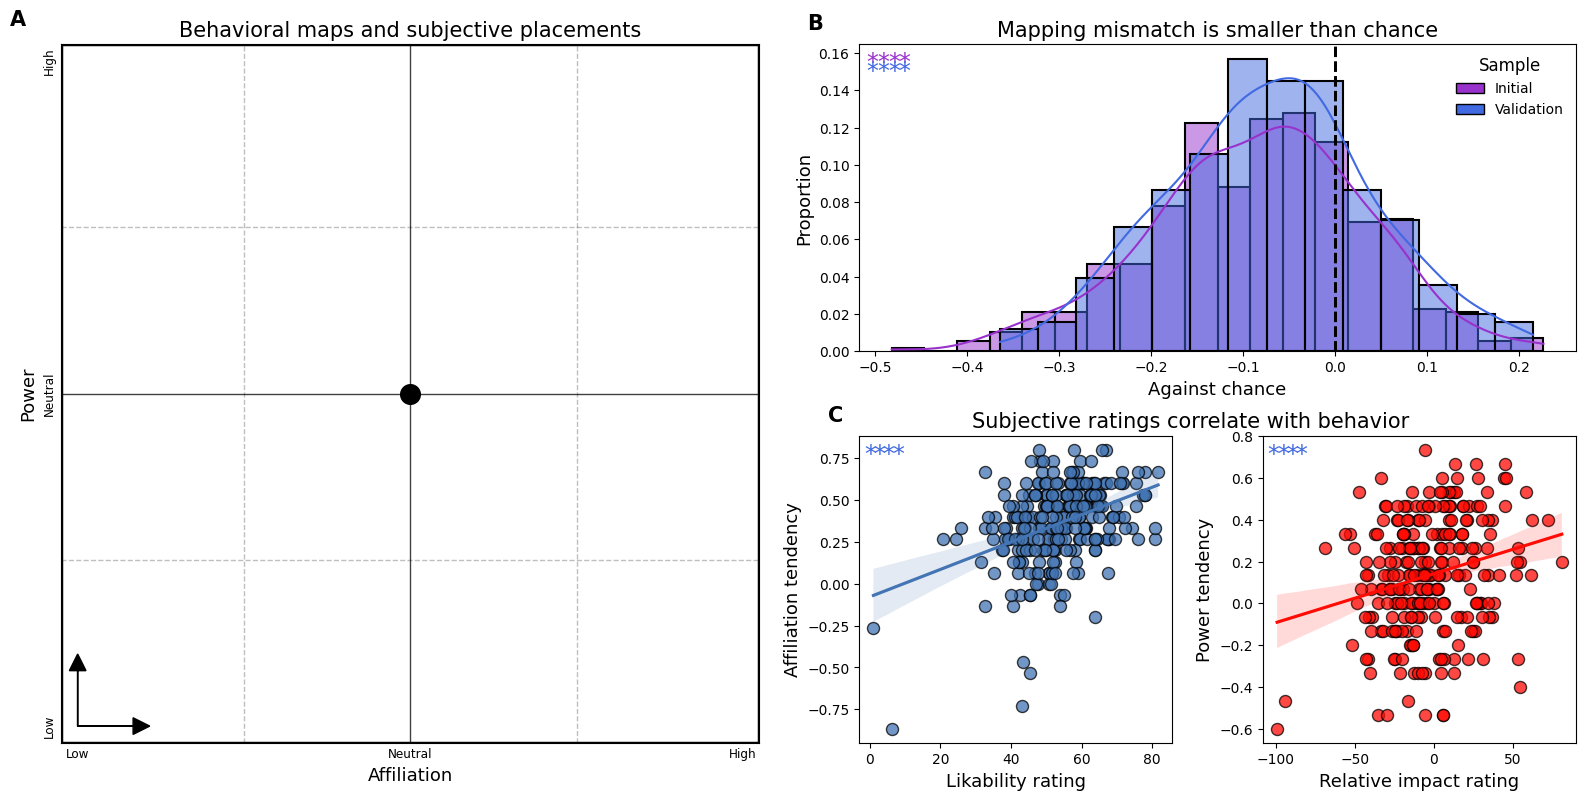

In [8]:
fig, axs = create_subplots((2,4), {(0,0): (2,2), (0,2): (1, 2)}, figsize=(16, 8), annotate=False)
# fig.suptitle('Behavioral geometry is consistent with subjective social mapping', fontsize=suptitle_fontsize, y=1.02)

#------------------------------------------------------------
# # soical space mapping
#------------------------------------------------------------


ax = axs[0]
add_subfig_letter(ax, 'A', y=1.05, fontsize=title_fontsize)
ax.set_title('Behavioral maps and subjective placements', fontsize=title_fontsize)
plot_social_space(ax, label_fontsize=label_fontsize)
# colors = ['r', 'b', 'g']
# XYs = np.array([[[.4, .5], [.2, .8]], 
#                 [[-.1, -.5], [-.7, -.8]],
#                 [[.23, -.67], [.7, -.72]]])
# for xy, color in zip(XYs, colors):
#     ax.scatter(*xy.T, s=100, c=color, zorder=1)


#------------------------------------------------------------
# permutation distance analysis
#------------------------------------------------------------

ax = axs[1]
add_subfig_letter(ax, 'B', fontsize=title_fontsize)
ax.set_title('Mapping mismatch is smaller than chance', fontsize=title_fontsize)
ax.set_ylabel('Proportion', fontsize=label_fontsize)
ax.set_xlabel('Against chance', fontsize=label_fontsize)
for s, sample in enumerate(samples[:2]):
    df = sample_dict[sample]['data']
    color = sample_colors[s]
    perm_diffs = df['beh_dots_dist_mean'] - df['beh_dots_dist_shuff_mean']
    ax = plot_histplot(perm_diffs, ax=ax, color=color, stat='probability')
    tp = ttest_1samp(perm_diffs, popmean=0, alternative='less')[1]
    print(f'{sample}: p={tp:.2f}')
    plot_significance(ax, tp, sig_level=4, color=color, x=0.01, y=0.98-s*0.03, fontsize=17)
    ax.axvline(0, color='black', linestyle='--', linewidth=2)

# add a legend for samples
handles = [mpatches.Patch(facecolor=sample_colors[s], edgecolor='black', hatch='', label=sample) for s, sample in enumerate(samples[:2])]
ax.legend(handles=handles, title='Sample', title_fontsize=legend_title_fontsize,
          loc='upper right', fontsize=legend_label_fontsize, frameon=False)


#------------------------------------------------------------
# plot rating correlations
#------------------------------------------------------------


df = sample_dict['Validation']['data']
plot_vars = [['likability', 'affil'], ['likability', 'power'], ['impact_diff', 'affil'], ['impact_diff', 'power']]

plt.figtext(.75, 0.48, 'Subjective ratings correlate with behavior', ha='center', va='center', fontsize=title_fontsize)

# likability & affil, impact_diff & power
ax = axs[2]
add_subfig_letter(ax, 'C', fontsize=title_fontsize)
ax = plot_regplot(df['likability_mean'], df['affil_mean_mean'], ax=ax, color="#4374B3")
res_df = run_ols(X='likability_mean', y='affil_mean_mean', data=df, covariates=all_controls)[0]
p = res_df[res_df['x']=='likability_mean']['p_right'].values[0]
plot_significance(ax, p, sig_level=4, color=sample_colors[1], x=0.015, y=0.98, dx=0.03, fontsize=17)
ax.set_xlabel('Likability rating', fontsize=label_fontsize)
ax.set_ylabel('Affiliation tendency', fontsize=label_fontsize)

ax = axs[3]
ax = plot_regplot(df['impact_diff_mean'], df['power_mean_mean'], ax=ax, color="#FF0B04")
res_df = run_ols(X='impact_diff_mean', y='power_mean_mean', data=df, covariates=all_controls)[0]
p = res_df[res_df['x']=='impact_diff_mean']['p_right'].values[0]
plot_significance(ax, p, sig_level=4, color=sample_colors[1], x=0.015, y=0.98, dx=0.03, fontsize=17)
ax.set_xlabel('Relative impact rating', fontsize=label_fontsize)
ax.set_ylabel('Power tendency', fontsize=label_fontsize)

# add snignificance for both
# for i, (rating, beh) in enumerate([['likability_mean', 'affil_mean_mean'], ['impact_diff_mean', 'power_mean_mean']]):
#     ols_df = run_ols(rating, beh, df)[0]
#     p = ols_df[ols_df['x'].isin([rating])]['p'].values[0]
#     plot_significance(axs[2+i], p, sig_level=4, x=0.85, y=0.06, dx=0.03, fontsize=17)
# fig.text(-0.01, 0.5, 'Character ratings', va='center', rotation='vertical', fontdict={'fontsize': 15})
# fig.text(0.5, -0.01, 'Interaction decisions', ha='center', fontdict={'fontsize': 15})

plt.subplots_adjust(hspace=0.7) # Adjust vertical_spacing = 0.5 * axes_height
plt.tight_layout()
save_figure(fig, f'{fig_dir}/Fig1_Behavioral-validation')

# Memory conjecture: smaller distance --> more confusion


Should see negative correlations on average: people confuse the characters in memory more the closer they placed them to each other in behavior & subjective placements...
- overall memory effct correlates positively with area in the subjective placements...
- dots & memory are both about memory recall, in diff ways... 
- dots is stronger relationship....

try: 
- area of map
- character-specific efffects
- MDS...

In [ ]:
memory_ques = ['memory_01_second','memory_02_boss', 'memory_03_neutral', 'memory_04_boss','memory_05_neutral',
               'memory_06_first','memory_07_first','memory_08_first','memory_09_boss','memory_10_second',
               'memory_11_powerful','memory_12_powerful','memory_13_second','memory_14_boss','memory_15_neutral',
               'memory_16_powerful','memory_17_second','memory_18_first','memory_19_assistant','memory_20_neutral',
               'memory_21_neutral','memory_22_assistant','memory_23_assistant','memory_24_assistant','memory_25_powerful',
               'memory_26_powerful','memory_27_first','memory_28_second','memory_29_assistant','memory_30_boss']

from frechetdist import frdist

def calc_memory_confusion(data: pd.DataFrame, include_neutral=False):

    memory_ques = ['memory_01_second', 'memory_10_second','memory_13_second','memory_17_second','memory_28_second',
                   'memory_02_boss', 'memory_04_boss', 'memory_09_boss','memory_14_boss','memory_30_boss',
                   'memory_03_neutral', 'memory_05_neutral','memory_15_neutral','memory_20_neutral','memory_21_neutral',
                   'memory_06_first', 'memory_07_first', 'memory_08_first', 'memory_27_first','memory_18_first',
                   'memory_11_powerful','memory_12_powerful', 'memory_16_powerful','memory_25_powerful','memory_26_powerful',
                   'memory_19_assistant', 'memory_22_assistant','memory_23_assistant','memory_24_assistant','memory_29_assistant']
    if include_neutral:
        roles = character_roles
    else: 
        roles = [role for role in character_roles if role != 'neutral']
    role_ques = {role: [col for col in memory_ques if role in col] for role in roles}
    data.reset_index(drop=True, inplace=True)
    confusion = np.zeros((data.shape[0], len(roles), len(roles)))
    for p in range(data.shape[0]):
        confusion_ = np.zeros((len(roles), len(roles)))
        for (q, ques), (a, answer) in itertools.product(enumerate(roles), enumerate(roles)):
            confusion_[q, a] = np.sum(data.loc[p, role_ques[ques]].values == answer)
        confusion[p, :, :] = symmetrize_matrix(confusion_) 
    return confusion

def get_trajectories():
    decision_data = get_cols('decision').values
    trajectories  = []
    for c in range(1, 6): 

        char_dims  = decision_trials[decision_trials['char_role_num'] == c]['dimension']
        affil_mask = char_dims.values == 'affil'
        power_mask = char_dims.values == 'power'

        character_decisions = decision_data[:, char_dims.index]
        character_coords = np.zeros((character_decisions.shape[0], 12, 2))
        character_coords[:, affil_mask, 0] = character_decisions[:, affil_mask]
        character_coords[:, power_mask, 1] = character_decisions[:, power_mask]
        trajectories.append(np.cumsum(character_coords, axis=1))

    trajectories = np.array(trajectories) 
    trajectories = np.transpose(trajectories, (1, 0, 2, 3)) # (n_subjects, n_characters, n_trials, n_dimensions)
    return trajectories

def calc_pairwise_frechet_distance(traj_data):
    # calculate pairwise frechet distance between all characters
    # traj_data: (n_characters, n_trials, n_dimensions)
    # distance_matrix: (n_characters, n_characters)
    distance_matrix = np.zeros((traj_data.shape[0], traj_data.shape[0]))
    for i, j in itertools.combinations(range(traj_data.shape[0]), 2):
        distance_matrix[i, j] = distance_matrix[j, i] = frdist(traj_data[i], traj_data[j])
    return distance_matrix


In [ ]:
include_neutral = True
n_ques = 25 if include_neutral else 30

#------------------------------------------------------------
# memory confusion
#------------------------------------------------------------

memory_df = data[memory_ques].copy()
assert memory_df.shape[1] == 30
confusion = calc_memory_confusion(memory_df, include_neutral=include_neutral) # memory confusion matrix

fig, ax = plt.subplots(1, 1, figsize=(4,4))
sns.heatmap(np.mean(confusion, axis=0), square=True, ax=ax)
ax.set_title('Average character confusion', fontsize=title_fontsize)
ax.set_xlabel('Characters', fontsize=label_fontsize)
ax.set_ylabel('Characters', fontsize=label_fontsize)
plt.tight_layout()

# # trajectory distance
# trajectories = get_trajectories()
# frechet_distances = np.zeros((trajectories.shape[0], 5, 5))
# for s in range(trajectories.shape[0]):
#     frechet_distances[s,:] = calc_pairwise_frechet_distance(trajectories[s])
# frechet_rdvs = np.vstack([symm_mat_to_ut_vec(dists) for dists in frechet_distances])
# traj_taus  = np.array([kendalltau(d, m)[0] for d, m in zip(frechet_rdvs, memory_rsvs)])
# p = wilcoxon(isfinite(traj_taus)[0], alternative='less')[1]
# print(f'behav traj wilcoxon p={p:.3f}')

#------------------------------------------------------------
# RSA: does the memory confusion matrix negatively correlate with spatial distance?
#------------------------------------------------------------

memory_rsvs = np.vstack([symm_mat_to_ut_vec(conf) / n_ques for conf in confusion]) # turn into fraction
memory_inc  = [np.sum(rdv) for rdv in memory_rsvs] # incorrect memory

# dots and task
dots_coords  = get_coords(data, which='dots', include_neutral=include_neutral)
dots_rdvs    = np.vstack([get_rdv(xy) for xy in dots_coords])
behav_coords = get_coords(data, which='task', include_neutral=include_neutral)
behav_rdvs   = np.vstack([get_rdv(xy) for xy in behav_coords])

# kendall tau --> wilcoxon(tau)
dots_taus  = np.array([kendalltau(d, m)[0] for d, m in zip(dots_rdvs, memory_rsvs)])
behav_taus = np.array([kendalltau(d, m)[0] for d, m in zip(behav_rdvs, memory_rsvs)])

# plot
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

ax = axs[0,0]
ax = plot_histplot(memory_inc, ax=ax)
ax.set_title('Memory incorrect (%)', fontsize=title_fontsize)

ax = axs[0,1]
ax = plot_regplot(memory_inc, data['memory_mean'], ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('Memory incorrect vs mean', fontsize=title_fontsize)

ax = axs[1,0]
ax = plot_histplot(dots_taus, ax=ax)
ax.set_title('Dots kendall tau', fontsize=title_fontsize)
p = wilcoxon(isfinite(dots_taus)[0], alternative='less')[1]
plot_significance(ax, p, color='black', x=0.02, dx=0.035)
ax.axvline(0, linestyle='--', color='red')

ax = axs[1,1]
ax = plot_histplot(behav_taus, ax=ax)
ax.set_title('Behavioral kendall tau', fontsize=title_fontsize)
p = wilcoxon(isfinite(behav_taus)[0], alternative='less')[1]
plot_significance(ax, p, color='black', x=0.02, dx=0.035)
ax.axvline(0, linestyle='--', color='red')

plt.tight_layout()

### Not an (obvious) temporal confound
If temporally confounded, expect more memory confusion with less distance (negative relationship)
- see the opposite - positive relationship... 
- why should it be that being more distant in time makes things more likely to be confused with one another?
- what else could explain???

In [ ]:
# get average temporal distance between characters...
char_temp_rdv = []
combos = list(itertools.combinations(range(1, 7), 2)) # pairwise number combinations between numbers 1 to 6
for combo in combos:
    slides_1 = decision_trials[decision_trials['char_role_num'] == combo[0]]['slide_num'].values
    slides_2 = decision_trials[decision_trials['char_role_num'] == combo[1]]['slide_num'].values
    dists    = pairwise_distances(slides_1[:,np.newaxis], slides_2[:,np.newaxis])
    char_temp_rdv.append(np.mean(dists))

# if it is a confound, we'd expect characters closer in time to be more confused for each other...
# we get the opposite... which I have to think about...
temp_dots_taus = np.array([kendalltau(d, char_temp_rdv)[0] for d in dots_rdvs])
p = wilcoxon(isfinite(temp_dots_taus)[0], alternative='less')[1]
print(f'temporal distance + dots xy wilcoxon p={p:.3f}')
print(f'mean = {np.nanmean(temp_dots_taus):.3f}, std = {np.nanstd(temp_dots_taus):.3f}')

temp_game_taus = np.array([kendalltau(d, char_temp_rdv)[0] for d in behav_rdvs])
p = wilcoxon(isfinite(temp_game_taus)[0], alternative='less')[1]
print(f'temporal distance + game xy wilcoxon p={p:.3f}')
print(f'mean = {np.nanmean(temp_game_taus):.3f}, std = {np.nanstd(temp_game_taus):.3f}')

# fig, axs = plt.subplots(1, 2, figsize=(9, 4))
# ax = axs[0]
# plot_histplot(temp_dots_taus, ax=ax)
# ax.set_xlabel('Kendall tau')
# ax.set_ylabel('Frequency')
# ax.set_title('Temporal & dots distance');

# ax = axs[1]
# plot_histplot(temp_game_taus, ax=ax)
# ax.set_xlabel('Kendall tau')
# ax.set_ylabel('Frequency')
# ax.set_title('Temporal & game distance');

### Characters further from the participant are also more likely to be confused in memory
- more distance means representing with less precision?
- BUT: *average* distance doesnt correlate w/ average memory, suggesting it's a within-subject effect, might be tricky to compare across subjects... making some hidden assumptions there

In [ ]:
memory   = data[[f'memory_{role}' for role in character_roles]].values
dist_beh = data[[f'pov_2d_dist_mean_{role}' for role in character_roles]].values
taus_beh = np.array([kendalltau(d, m)[0] for d, m in zip(dist_beh, memory)])

# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
for s, sample in enumerate(samples[:2]):
    taus_beh_ = taus_beh[data['sample'] == s]
    plot_histplot(taus_beh_, ax=ax, kde=True, color=sample_colors[s])
    p = wilcoxon(isfinite(taus_beh_)[0], alternative='less')[1]
    plot_significance(ax, p, color=sample_colors[s], x=0.02, y=0.975 - s*0.025, dx=0.02)
    ax.axvline(0, linestyle='--', color='red')
    ax.set_xlabel('Kendall tau');

### Smaller dots area (but not behavior), worse memory

In [ ]:
# end of task area
task_xy = get_coords(data, which='task', include_neutral=False)
data['area_end'] = [calc_area(xy) for xy in task_xy]
sample_dict = update_sample_dict(data)
for sample in samples[:2]:
    res = run_ols(X='memory_mean', y='dots_area', data=sample_dict[sample]['data'], covariates=demo_controls + other_controls)[0]
    display(res[res['x']=='memory_mean'])

In [ ]:
def calc_area(xy):
    try: 
        return scipy.spatial.ConvexHull(xy[~np.isnan(xy)].reshape(-1, 2)).volume
    except:
        return np.nan
    
# end of game location area doesnnt relate to memory confusability... maybe trajectory similarity does...?
family        = ['marriage', 'dating', 'children', 'parents', 'relatives', 'inlaws']
nonfamily     = ['friends', 'school', 'neighbors', 'workNonsupervision', 'workSupervision', 'religion', 'volunteer', 'extraGroup1']
relationships = family + nonfamily

try: 
    relationship_cols = np.unique([('_').join(c.split('_')[0:2]) for c in data.columns if c.split('_')[0] in relationships])
    nonfamily_cols = [c for c in relationship_cols if c.split('_')[0] in nonfamily]
    family_cols    = [c for c in relationship_cols if c.split('_')[0] in family]
except:
    print('no data to get the relationhip columns from')

for fam, cols in {'family': family_cols, 'nonfamily': nonfamily_cols, 'relationship': relationship_cols}.items():
    data[f'dots_affil_{fam}_mean'] = np.nanmean(data[[f'{c}_dots_affil_relationship' for c in cols]], 1)
    data[f'dots_power_{fam}_mean'] = np.nanmean(data[[f'{c}_dots_power_relationship' for c in cols]], 1)
    data[f'likability_{fam}_mean'] = np.nanmean(data[[f'{c}_likability_relationship' for c in cols]], 1)
    data[f'impact_{fam}_mean']     = np.nanmean(data[[f'{c}_impact_relationship' for c in cols]], 1)
    data[f'{fam}_dots_area']       = np.array([calc_area(xy) for xy in get_coords(data, which=f'{fam}_dots')])
    data[f'{fam}_ratings_area']    = np.array([calc_area(xy) for xy in get_coords(data, which=f'{fam}_ratings')])
sample_dict = update_sample_dict(data)

# Explore other possible spatial representations
seems like I should be able to find a better explanation for the dots locations, but can't yet (at least looking at taus..)

In [ ]:
xy_coords = get_coords(data, which='task', include_neutral=True).reshape(-1, 2)
xy_coords = pd.DataFrame(xy_coords, columns=['x','y'])
xy_df = xy_coords.groupby(['x', 'y']).size().reset_index(name='counts')
errors = data[[f'beh_dots_dist_{role}' for role in character_roles]].values.flatten()
xy_coords = xy_coords.merge(xy_df, how='left', on=['x', 'y']) # not exactly right: multipple rows with same x,y and counts....
xy_coords['error'] = errors

import matplotlib.colors as mcolors
from scipy.interpolate import griddata


fig, axs = plt.subplots(1, 4, figsize=(20, 4))
ax = axs[0]
ax.scatter(x=xy_coords['x'], y=xy_coords['y'],  c=xy_coords['error'], s=xy_coords['counts']*20,
            cmap='Reds', edgecolor='black', linewidth=1, alpha=0.75)
# cbar.set_label('Mapping mismatch', fontsize=label_fontsize)
# ax.set_title('Spatial Distribution of Errors')
plot_social_space(ax, label_fontsize=14, origin_size=0)

for i, method in enumerate(['nearest', 'linear', 'cubic']):
    ax = axs[1+i]
    grid_x, grid_y = np.mgrid[-1:1:200j, -1:1:200j]  # nj specifies n points along each dimension
    grid_z = griddata(xy_coords[['x','y']], xy_coords['error'], (grid_x, grid_y), method=method)
    ax.imshow(grid_z.T, extent=(-1, 1, -1, 1), origin='lower', cmap='Reds')
    ax.set_title(f'{method} interpolation')
    plot_social_space(ax, label_fontsize=14, origin_size=0)

plt.show()

In [ ]:
# instead of interpolation, maybe somehow estimate rings or something? ...
def locations_with_distance_decay(D, type='1D'):
    if type == '1D':
        # both dimensions independently
        xy = []
        for dim in D.T:
            locs = []
            for i, d in enumerate(dim):
                loc_prev = locs[i-1] if i > 0 else 0
                r = np.abs(loc_prev)
                w = (1 / r) if r > 0 else 1
                locs.append(loc_prev + w * d)
            xy.append(locs)
        return np.array(xy).T
    elif type == '2D':
        locs = []
        for i, d in enumerate(D):
            loc_prev = locs[i-1] if i > 0 else 0
            r = norm(loc_prev)
            w = (1 / r) if r > 0 else 1
            locs.append(loc_prev + w * d)
        return np.array(locs)

def linear_decay(w0, k, t):
    """
    Calculates the linearly decaying weight over a specified number of time steps.
    
    Args:
    - w0 (float): initial weight
    - k (float): decay rate
    - t (int): number of time steps to calculate the decay for
    
    Returns:
    - list: updated weights after linear decay for each time step, ensuring no negative values.
    """
    return np.array([max(w0 - k * i, 0) for i in range(t)])

def exponential_decay(w0, k, t):
    """
    Calculates the exponentially decaying weight over a specified number of time steps.
    
    Args:
    - w0 (float): initial weight
    - k (float): decay rate
    - t (int): number of time steps to calculate the decay for
    
    Returns:
    - list: updated weights after exponential decay for each time step.
    """
    return np.array([w0 * np.exp(-k * i) for i in range(t)])

def inverse_time_decay(w0, k, t):
    """
    Calculates the inversely decaying weight over a specified number of time steps.
    
    Args:
    - w0 (float): initial weight
    - k (float): decay rate
    - t (int): number of time steps to calculate the decay for
    
    Returns:
    - list: updated weights after inverse time decay for each time step.
    """
    return np.array([w0 / (1 + k * i) for i in range(t)])

def stepwise_decay(w0, k, n, t):
    """
    Calculates the stepwise decaying weight over a specified number of time steps.
    
    Args:
    - w0 (float): initial weight
    - k (float): decay factor
    - n (int): number of decisions after which the decay happens
    - t (int): number of time steps to calculate the decay for
    
    Returns:
    - list: updated weights after stepwise decay for each time step, ensuring no negative values.
    """
    return np.array([max(w0 * (k ** (i // n)), 0) for i in range(t)])

In [ ]:
dots_xys_ = get_coords(data, which='dots', include_neutral=True)

taus = []
for i in range(len(data)): 

    dots_xys  = dots_xys_[i]

    behav     = load_behav(data['sub_id'].values[i])
    decisions = organize_by_character(behav[['affil_decision', 'power_decision']].values)

    # regular updates
    xys = [np.cumsum(d, 0) for d in decisions]
    xys = np.array([xy[-1] for xy in xys])

    # # simple running average - would imply the max someone could get close is on trial 1
    # xys_running = [np.cumsum(d, axis=0) / np.arange(1, d.shape[0]+1)[:,None] for d in decisions]
    # xys_running = np.array([xy[-1] for xy in xys_running])

    # updates weighted as an linear decay function of interacton number
    xys_lin = [d * linear_decay(1, 1/len(d), len(d))[:,np.newaxis] for d in decisions]
    xys_lin = np.array([xy[-1] for xy in xys_lin])

    # updates weighted as an exponential decay function of interacton number
    xys_exp = [d * exponential_decay(1, 1/len(d), len(d))[:,np.newaxis] for d in decisions]
    xys_exp = np.array([xy[-1] for xy in xys_exp])

    # updates ...
    xys_inv = [d * inverse_time_decay(1, 1/len(d), len(d))[:,np.newaxis] for d in decisions]
    xys_inv = np.array([xy[-1] for xy in xys_inv])

    # distance based decay
    xys_dist_1d = [locations_with_distance_decay(D) for D in decisions]
    xys_dist_1d = np.array([xy[-1] for xy in xys_dist_1d])

    xys_dist_2d = [locations_with_distance_decay(D, type='2D') for D in decisions]
    xys_dist_2d = np.array([xy[-1] for xy in xys_dist_2d])
    
    assert xys.shape == dots_xys.shape == xys_lin.shape
    
    # correlate
    dots_rdv = get_rdv(dots_xys)
    taus_ = []
    for xys_ in [xys, xys_lin, xys_exp, xys_inv, xys_dist_1d, xys_dist_2d]:
        taus_.append(kendalltau(get_rdv(xys_), dots_rdv)[0])
    taus.append(taus_)
    
tau_df = pd.DataFrame(np.array(taus), columns=['xys', 'xys_lin', 'xys_exp', 'xys_inv', 'xys_dist_1D', 'xys_dist_2D'])

# visualize!
# fig, ax = plt.subplots(1,1, figsize=(5,5))
# sns.scatterplot(x=xys[0][:,0], y=xys_lin[0][:,0], ax=ax)

In [ ]:
display(tau_df.mean())

# plot each column as a histogram
fig, ax = plt.subplots(1,1, figsize=(5,5))
for col in tau_df.columns:
    sns.histplot(tau_df[col], ax=ax, kde=True, label=col)
ax.legend()
ax.axvline(0, linestyle='--', color='red')
plt.show()

In [ ]:
# correlations per subject
distances = data[[f'pov_2d_dist_mean_{role}' for role in character_roles]].values # distance to self
errors = data[[f'beh_dots_dist_{role}' for role in character_roles]].values # mapping mismatch
taus = np.array([kendalltau(d, m)[0] for d, m in zip(distances, errors)]) # only 6 values per subject... probably want some model across all subjects...
p = wilcoxon(isfinite(taus)[0], alternative='less')[1]
print(f'p={p:.3f}')

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
ax = plot_histplot(taus, bins=15, ax=ax)
ax.set_title('Correlations between self-distance and mapping mismatch', fontsize=title_fontsize)
plot_significance(ax, p, color='black', x=0.02, dx=0.025)
ax.axvline(0, linestyle='--', color='red')
plt.show()

In [ ]:
# get coordinates
dots_xy = get_coords(data, which='dots', include_neutral=True) # range=[-1, +1]
beh_xy  = get_coords(data, which='task', include_neutral=True) # range=[-1, +1]

# get distances to self and the mapping mismatch
errors    = np.array([norm(beh_xy[i]-dots_xy[i], axis=1) for i in range(beh_xy.shape[0])]) # mapping mismatch
distances = np.vstack([norm(xy-np.array([1,0]), axis=1) for xy in beh_xy]) + 0.0001 # distances to self

# calculate diff. models
models = {
    "Inverse Proportional": [1 / d for d in distances],
    "Inverse Exponential": [np.exp(-1 / d) for d in distances],
    "Logarithmic Inverse": [np.log(1 / d) for d in distances]
}

for model_name, transformed_distances in models.items():

    # none of these wil change the ranks, so wont change the tau
    taus = np.array([kendalltau(d, m)[0] for d, m in zip(errors, transformed_distances)]) # only 6 values per subject...
    p = wilcoxon(isfinite(taus)[0])[1]
    print(f'p={p:.3f}')

    fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
    ax = plot_histplot(taus, bins=15, ax=ax)
    ax.set_title('Correlations between self-distance and mapping mismatch', fontsize=title_fontsize)
    # p = wilcoxon(isfinite(taus)[0], alternative='less')[1]
    # plot_significance(ax, p, color='black', x=0.02, dx=0.025)
    ax.axvline(0, linestyle='--', color='red')
    plt.show()


#     slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(transformed_distances, errors)
#     plt.scatter(transformed_distances, errors, label=model_name)
#     plt.plot(transformed_distances, [slope * x + intercept for x in transformed_distances], label=f"Fit: {model_name}")
#     print(f"{model_name} - Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}, P-value: {p_value}")


# # pov_beh_dists_log = np.mean(np.log(pov_beh_dists + 0.0001), axis=1)
# pov_beh_dists_log = np.log(np.mean(pov_beh_dists, axis=1))

# fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

# ax = axs[0]
# sns.regplot(x=np.mean(pov_beh_dists, axis=1), y=pov_beh_dists_log, color='grey', ax=ax)
# ax.set_xlabel('Mean distance from self', fontsize=label_fontsize)
# ax.set_ylabel('Log distance from self', fontsize=label_fontsize);

# ax = axs[1]
# sns.regplot(x=beh_dots_dists, y=pov_beh_dists_log, color='grey', ax=ax)
# ax.set_xlabel('Mapping mismatch', fontsize=label_fontsize)

# plt.tight_layout()